In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer



In [ ]:
# Load the dataset
data = pd.read_csv("Crime.csv")

print(data.head())

print(data.info())

In [ ]:
# Check for missing values
print(data.isnull().sum())

data.fillna(0, inplace=True)


STATE/UT                                               0
DISTRICT                                               0
YEAR                                                   0
MURDER                                                 0
ATTEMPT TO MURDER                                      0
CULPABLE HOMICIDE NOT AMOUNTING TO MURDER              0
RAPE                                                   0
OTHER RAPE                                             0
KIDNAPPING & ABDUCTION                                 0
DACOITY                                                0
ROBBERY                                                0
BURGLARY                                               0
THEFT                                                  0
AUTO THEFT                                             0
OTHER THEFT                                            0
RIOTS                                                  0
CRIMINAL BREACH OF TRUST                               0
CHEATING                       

In [ ]:
# Drop non-informative columns for modeling
selected_data = data.drop(columns=['STATE/UT', 'DISTRICT'])

# Calculate correlation to check for highly correlated features
correlation_matrix = selected_data.corr()

# Display correlation matrix to decide if any features can be dropped
print(correlation_matrix)


                                                        YEAR    MURDER  \
YEAR                                                1.000000 -0.015223   
MURDER                                             -0.015223  1.000000   
ATTEMPT TO MURDER                                   0.010264  0.943333   
CULPABLE HOMICIDE NOT AMOUNTING TO MURDER          -0.010392  0.783776   
RAPE                                                0.054591  0.791478   
OTHER RAPE                                          0.054400  0.791181   
KIDNAPPING & ABDUCTION                              0.061612  0.779831   
DACOITY                                            -0.036543  0.789266   
ROBBERY                                             0.037085  0.764097   
BURGLARY                                           -0.006380  0.762559   
THEFT                                               0.028768  0.798456   
AUTO THEFT                                          0.067914  0.723232   
OTHER THEFT                           

In [ ]:
# Calculate YoY change for each crime type
for crime_type in data.columns[2:]:  # Skipping 'YEAR'
    data[f'{crime_type}_yoy_change'] = data.groupby('DISTRICT')[crime_type].pct_change() * 100


<ipython-input-19-fed0aea71cd7>:6: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[f'{crime_type}_yoy_change'] = data.groupby('DISTRICT')[crime_type].pct_change() * 100
<ipython-input-19-fed0aea71cd7>:6: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[f'{crime_type}_yoy_change'] = data.groupby('DISTRICT')[crime_type].pct_change() * 100
<ipython-input-19-fed0aea71cd7>:6: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or spe

In [ ]:
# Calculate rolling mean (3-year window) for each crime type
for crime_type in data.columns[2:]:
    data[f'{crime_type}_3yr_avg'] = data.groupby('DISTRICT')[crime_type].rolling(window=3).mean().reset_index(level=0, drop=True)


In [ ]:
# Binary target for increase (1) or decrease (0) in total IPC crimes
data['total_ipc_crimes_increase'] = (data['total_ipc_crimes_3yr_avg_yoy_change'].diff() > 0).astype(int)


<ipython-input-26-f8e824173313>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['total_ipc_crimes_increase'] = (data['total_ipc_crimes_3yr_avg_yoy_change'].diff() > 0).astype(int)


In [ ]:
# Create lag features (1-year lag)
for crime_type in data.columns[2:]:
    data[f'{crime_type}_lag1'] = data.groupby('district')[crime_type].shift(1)


<ipython-input-29-fc65e51be09b>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{crime_type}_lag1'] = data.groupby('district')[crime_type].shift(1)
<ipython-input-29-fc65e51be09b>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{crime_type}_lag1'] = data.groupby('district')[crime_type].shift(1)
<ipython-input-29-fc65e51be09b>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

In [ ]:
# Example: Theft to Burglary ratio
data['theft_to_burglary_ratio'] = data['theft'] / (data['burglary'] + 1)


<ipython-input-32-897302348921>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['theft_to_burglary_ratio'] = data['theft'] / (data['burglary'] + 1)


In [1]:
# Drop rows with NaN values after feature engineering
final_data = data.dropna()

# Save the final dataset
final_data.to_csv("final_crime_data.csv", index=False)


NameError: name 'data' is not defined

In [5]:
data = pd.read_csv("final_crime_data.csv")
encoded_data = pd.get_dummies(data, columns=['district'], prefix='DISTRICT')

print(encoded_data.head())


            state/ut  year  murder  attempt_to_murder  \
0  ARUNACHAL PRADESH  2002      61                 38   
1  ARUNACHAL PRADESH  2003      77                 20   
2   HIMACHAL PRADESH  2003       8                  5   
3      UTTAR PRADESH  2003      15                  4   
4           DELHI UT  2003      44                 38   

   culpable_homicide_not_amounting_to_murder  rape  other_rape  \
0                                          6    38          38   
1                                          3    31          31   
2                                          0    13          13   
3                                          7     3           3   
4                                          6    37          37   

   kidnapping_&_abduction  dacoity  robbery  ...  DISTRICT_VELLORE  \
0                      57       22       96  ...             False   
1                      68       37       60  ...             False   
2                      12        2        2  ...  

In [64]:

# Assuming 'encoded_data' is the DataFrame after encoding, and 'target' is the target column name
# Define your target variable. For example, let's assume we're predicting increase/decrease in 'TOTAL IPC CRIMES'
encoded_data['crime_increase'] = (encoded_data['total_ipc_crimes'].diff() > 0).astype(int)

# Drop columns that are not needed for training
X = encoded_data.drop(columns=['total_ipc_crimes', 'year'])
y = encoded_data['crime_increase']

# Before splitting into train/test, identify and encode object (string) columns
for col in X.select_dtypes(include=['object']).columns:
    # Create a LabelEncoder for each categorical column
    le = LabelEncoder()
    # Fit and transform the column in the entire dataset (X)
    X[col] = le.fit_transform(X[col])

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(strategy='mean')  # You can change the strategy if needed
X = imputer.fit_transform(X)

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Further split the training data into training and validation sets (if needed)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 60% train, 20% val, 20% test

# Display the shapes of the datasets
print("Training set shape:", X_train.shape)
#print("Validation set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (376, 518)
Testing set shape: (94, 518)


In [16]:

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=200, random_state=42)
# Train the model on the training set
log_reg.fit(X_train, y_train)
# Predict on the test set
y_pred = log_reg.predict(X_test)




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [71]:
# Evaluate the model
acuracy_1 = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.5531914893617021
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.58      0.54        43
           1       0.60      0.53      0.56        51

    accuracy                           0.55        94
   macro avg       0.56      0.56      0.55        94
weighted avg       0.56      0.55      0.55        94



In [18]:
# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)  # Set max_depth to control overfitting

# Train the model
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test)




In [72]:
acuracy_2 = accuracy_score(y_test, y_pred_dt)
# Evaluate the model
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report for Decision Tree:\n", classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 1.0
Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        51

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94



In [20]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)  # Set max_depth and n_estimators

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

In [73]:
acuracy_3 = accuracy_score(y_test, y_pred_rf)
# Evaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9574468085106383
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95        43
           1       0.98      0.94      0.96        51

    accuracy                           0.96        94
   macro avg       0.96      0.96      0.96        94
weighted avg       0.96      0.96      0.96        94



In [21]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)



In [74]:
acuracy_4 = accuracy_score(y_test, y_pred_xgb)
# Evaluate the model
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report for XGBoost:\n", classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 1.0
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        51

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94



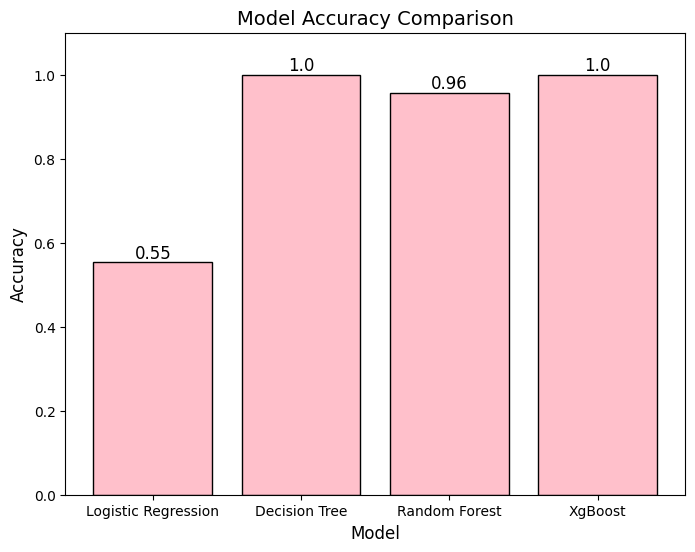

In [84]:
import matplotlib.pyplot as plt

# Example: Accuracy of each model (replace with actual accuracy values)
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XgBoost']
model_accuracies = [acuracy_1,acuracy_2,acuracy_3, acuracy_4]  # Example accuracies, replace with actual

# Create a bar plot to represent the accuracy of each model
plt.figure(figsize=(8,6))
plt.bar(model_names, model_accuracies, color='Pink', edgecolor='black')

# Adding titles and labels
plt.title('Model Accuracy Comparison', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Display the accuracy values on top of the bars
for i, v in enumerate(model_accuracies):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center', fontsize=12)

# Show the plot
plt.ylim([0, 1.1])  # Set y-axis limit for better visualization
plt.show()



In [65]:

import numpy as np
from collections import Counter
default_features = np.zeros(518)  # Replace 518 with the actual number of features in your model

default_features[0] = 877  # Example: 'total_ipc_crimes'
default_features[1] = 2022   # Example: 'year'

In [66]:
# Predict using the trained model
unseen_prediction = xgb_model.predict([default_features])

# Map the prediction to a readable output
result1 = "Increase" if unseen_prediction[0] == 1 else "Decrease"

# Print the result
print(f"Crime Prediction for given input: {result1}")

Crime Prediction for given input: Decrease


In [67]:
unseen_prediction = log_reg.predict([default_features])

# Map the prediction to a readable output
result2 = "Increase" if unseen_prediction[0] == 1 else "Decrease"
# Print the result
print(f"Crime Prediction for given input: {result2}")

Crime Prediction for given input: Decrease


In [68]:
# Predict using the trained model
unseen_prediction = dt_model.predict([default_features])

# Map the prediction to a readable output
result3 = "Increase" if unseen_prediction[0] == 1 else "Decrease"

# Print the result
print(f"Crime Prediction for given input: {result3}")

Crime Prediction for given input: Decrease


In [69]:
# Predict using the trained model
unseen_prediction = rf_model.predict([default_features])

# Map the prediction to a readable output
result4 = "Increase" if unseen_prediction[0] == 1 else "Decrease"

# Print the result
print(f"Crime Prediction for given input: {result4}")

Crime Prediction for given input: Decrease


In [70]:
model_predictions = [result1, result2, result3, result4]

# Count occurrences of each prediction
vote_counts = Counter(model_predictions)

# Determine the majority prediction
majority_prediction = vote_counts.most_common(1)[0][0]

# Map the majority prediction to a readable output
final_result = "Increase" if majority_prediction == 1 else "Decrease"

# Print the final majority vote result
print(f"Final Prediction based on majority vote: {final_result}")


Final Prediction based on majority vote: Decrease
